In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
# For Notebooks
init_notebook_mode(connected=True)

In [2]:
class Company:
    
    risk_free_rate = 0.0125
    required_rate_of_return = 0.15
    
    def __init__(self, ticker, data):
        self.number_of_projected_years = len(data.axes[1]) - 1
        self.current_assets = data['current_assets']
        self.current_liabilities = data['current_liabilities']
        self.total_liabilities = data['total_liabilities']
        self.equity = data['equity']
        self.eps = data['eps']
        self.share_price = data['share_price']
        self.revenue = data['revenue']
        self.ppe = data['ppe']
        self.operating_cash_flow = data['operating_cash_flow']
        self.current_dividend_per_share = data.loc['2019', 'historical_dividends']
        self.historical_dividends = data['historical_dividends']
        self.lt_debt = data['lt_debt']
        self.current_shares_outstanding = data.loc['2019', 'shares_outstanding']
        self.ticker = ticker

    def get_current_ratio(self):
        return round(self.current_assets / self.current_liabilities, 2)

    def get_debt_to_equity(self):
        return round(self.total_liabilities / self.equity, 2)

    def price_to_eps(self):
        return round(self.share_price / self.eps.replace({0 : np.nan}), 2)    

    def eps_growth(self):
        return round(float(pd.DataFrame(self.eps.replace({0 : np.nan})).pct_change().mean(skipna = True) * 100), 2)

    def get_avg_revenue_growth(self):
        return round(float(pd.DataFrame(self.revenue).pct_change().mean(skipna = True) * 100), 2)

    def get_g_m_capex_per_year(self):
        ppe_to_revenue = self.ppe / self.revenue
        revenue_increase = [
            np.nan if i == 0 else self.revenue[i] - self.revenue[i - 1] for i, revenue in  enumerate(self.revenue)
        ]
        gcapex = ppe_to_revenue * revenue_increase
        mcapex = self.ppe - gcapex
        return mcapex

    def get_cash_for_owners(self):
        cash_for_owners = round(self.operating_cash_flow - self.get_g_m_capex_per_year(), 2)
        return cash_for_owners 
        
    def get_avg_owners_cash_growth(self):
        return round(float(pd.DataFrame(self.get_cash_for_owners().replace({0 : np.nan})).pct_change().mean(skipna = True) * 100), 2)

    def get_dividend_yield(self):
        return round(self.current_dividend_per_share / self.share_price * 100, 2)

    def get_roic(self):
        return round((self.get_cash_for_owners() / (self.lt_debt.replace({np.nan : 0}) + self.equity)) * 100, 2)

    def get_discounted_cash_flow_valuation(self, growth_rate):
        dcf = []
        for i in range(0, self.number_of_projected_years + 2):
            if i == 0:
                dcf.append((self.get_cash_for_owners()['2019'] + self.get_cash_for_owners()['2018']) / 2)
            else:
                dcf.append(dcf[-1] * (1 + growth_rate))
            if i == self.number_of_projected_years + 1:
                dcf.append(dcf[-1] * 10)
        return dcf

    def get_company_intrinsic_value(self, growth_rate):
        return round(np.npv(self.risk_free_rate, self.get_discounted_cash_flow_valuation(growth_rate)), 2)

    def get_company_buy_price(self, growth_rate):
        return np.npv(self.required_rate_of_return, self.get_discounted_cash_flow_valuation(growth_rate)) / self.current_shares_outstanding

    def get_dividend_discount_model_valuation(self):
        dividend_growth = self.historical_dividends.pct_change().mean()
        return self.current_dividend_per_share / (self.required_rate_of_return - dividend_growth / 100)
    
    def get_current_stock_price(self):
        try:
            tickerSymbol = (self.ticker + '.AX').upper()
            ticker_data = yf.Ticker(tickerSymbol)
            today_date = date.today()
            today_name = date.today().strftime('%A')
            if today_name == 'Saturday':
                today_date = (date.today() - timedelta(days = 1))
            if today_name == 'Sunday':
                today_date = (date.today() - timedelta(days = 2))
            tomorrow = today_date + timedelta(days = 1)
            ticker_df = pd.DataFrame(ticker_data.history(period = '1d', start = today_date, end = tomorrow)).reset_index()
            current_price = ticker_df.iloc[0]['Close']
            return current_price
        except:
            return 0 
        
    def plot_growth_rate_vs_buy_price(self, max_growth_rate, min_growth_rate = 0):
        growth_rate_array = np.linspace(min_growth_rate, max_growth_rate, 100)
        buy_price_array = [self.get_company_buy_price(growth_rate) for growth_rate in growth_rate_array]
        plt.xlabel('Growth Rate')
        plt.ylabel('Buy Price ($)')
        plt.axhline(y = max(buy_price_array) * 0.75, color = 'grey', alpha = 0.3, ls = '--', lw = 1)
        plt.axhline(y = max(buy_price_array) * 0.50, color = 'grey', alpha = 0.3, ls = '--', lw = 1)
        plt.axhline(y = max(buy_price_array) * 0.25, color = 'grey', alpha = 0.3, ls = '--', lw = 1)
        plt.axhline(y = self.get_current_stock_price(), color = 'red', alpha = 0.3, ls = '--', lw = 1)
        plt.plot(growth_rate_array, buy_price_array)

In [3]:
def stock_analysis_output(company_instance, max_growth_rate):
    company_instance.plot_growth_rate_vs_buy_price(max_growth_rate)
    print("AVG revenue growth\n",
    company_instance.get_avg_revenue_growth(),
    "\n\nAVG EPS growth\n",
    company_instance.eps_growth(),
    "\n\nCash for owners\n",
    company_instance.get_cash_for_owners(),
    "\n\nAVG cash growth\n",
    company_instance.get_avg_owners_cash_growth(),
    "\n\nROIC\n",
    company_instance.get_roic(),
    "\n\nP/E\n",
    company_instance.price_to_eps(),
    "\n\nDebt to equity\n",
    company_instance.get_debt_to_equity(),
    "\n\nCurrent ratio - assets to liabilities\n",
    company_instance.get_current_ratio(),
    "\n\n Current price (red line)\n",
    company_instance.get_current_stock_price())

AVG revenue growth
 77.52 

AVG EPS growth
 120.11 

Cash for owners
 2015       NaN
2016     20.18
2017     93.72
2018    209.53
2019    274.96
dtype: float64 

AVG cash growth
 173.07 

ROIC
 2015      NaN
2016    15.89
2017    40.75
2018    41.08
2019    36.52
dtype: float64 

P/E
 2015       NaN
2016     55.25
2017    101.67
2018     56.20
2019     41.95
dtype: float64 

Debt to equity
 2015    0.52
2016    0.57
2017    0.43
2018    0.30
2019    0.26
dtype: float64 

Current ratio - assets to liabilities
 2015    2.08
2016    2.38
2017    2.54
2018    3.03
2019    3.30
dtype: float64 

 Current price (red line)
 17.75


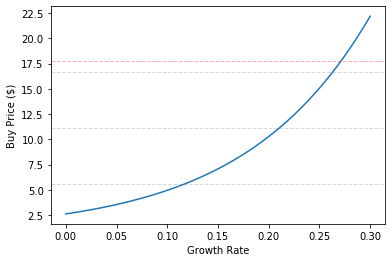

In [4]:
a2m_data = pd.read_csv('a2m.csv', index_col=0).transpose()
a2m = Company('a2m', a2m_data)
stock_analysis_output(a2m,0.30)

AVG revenue growth
 19.29 

AVG EPS growth
 165.8 

Cash for owners
 2010      NaN
2011     1.82
2012     7.17
2013    12.18
2014    19.12
2015      NaN
2016    15.70
2017    41.75
2018    62.17
2019    93.54
dtype: float64 

AVG cash growth
 83.53 

ROIC
 2010       NaN
2011     45.50
2012     79.67
2013    243.60
2014    239.00
2015       NaN
2016      8.92
2017     22.94
2018     30.03
2019     35.57
dtype: float64 

P/E
 2010     -1.93
2011     -2.00
2012      3.00
2013    100.00
2014     23.09
2015      3.40
2016     23.67
2017     26.71
2018     50.95
2019     45.12
dtype: float64 

Debt to equity
 2010    2.56
2011    5.75
2012    3.78
2013    9.00
2014    6.12
2015    0.41
2016    0.50
2017    0.51
2018    0.53
2019    0.51
dtype: float64 

Current ratio - assets to liabilities
 2010    0.91
2011    0.82
2012    1.00
2013    1.00
2014    1.23
2015    2.04
2016    1.52
2017    1.41
2018    1.50
2019    1.82
dtype: float64 

 Current price (red line)
 34.78


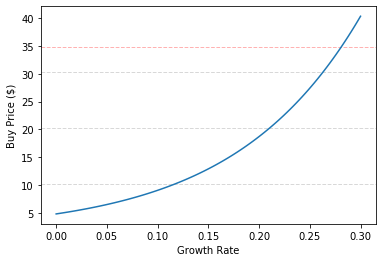

In [5]:
alu_data = pd.read_csv('alu.csv', index_col=0).transpose()
alu = Company('alu', alu_data)
stock_analysis_output(alu, 0.30)

AVG revenue growth
 7.05 

AVG EPS growth
 14.34 

Cash for owners
 2010      NaN
2011    40.59
2012    46.17
2013    29.17
2014    39.71
2015    22.43
2016    39.19
2017    44.94
2018    71.34
2019    35.98
dtype: float64 

AVG cash growth
 8.51 

ROIC
 2010      NaN
2011    26.36
2012    25.23
2013    13.76
2014    16.76
2015     8.87
2016    15.31
2017    15.18
2018    21.75
2019    10.08
dtype: float64 

P/E
 2010     9.29
2011    13.88
2012     9.14
2013    14.61
2014    26.32
2015    19.39
2016    17.31
2017    22.95
2018    28.98
2019    24.75
dtype: float64 

Debt to equity
 2010    0.59
2011    0.58
2012    0.57
2013    0.68
2014    0.58
2015    0.56
2016    0.50
2017    0.61
2018    0.57
2019    0.64
dtype: float64 

Current ratio - assets to liabilities
 2010    2.05
2011    2.08
2012    2.41
2013    2.10
2014    2.52
2015    2.48
2016    2.40
2017    2.57
2018    2.90
2019    2.57
dtype: float64 

 Current price (red line)
 22.08


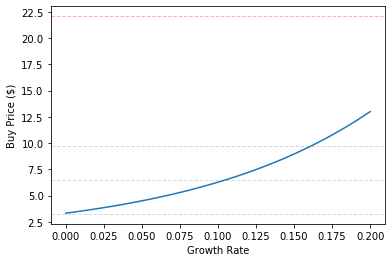

In [6]:
brg_data = pd.read_csv('brg.csv', index_col=0).transpose()
brg = Company('brg', brg_data)
stock_analysis_output(brg, 0.20)

AVG revenue growth
 15.02 

AVG EPS growth
 12.2 

Cash for owners
 2010       NaN
2011     57.59
2012     67.35
2013     86.43
2014     99.18
2015    100.49
2016    116.37
2017    122.23
2018    111.46
2019    122.42
dtype: float64 

AVG cash growth
 10.4 

ROIC
 2010      NaN
2011    52.83
2012    52.62
2013    56.49
2014    28.18
2015    22.74
2016    23.99
2017    26.12
2018    20.45
2019    15.38
dtype: float64 

P/E
 2010    25.53
2011    20.58
2012    17.03
2013    25.94
2014    26.72
2015    23.95
2016    26.13
2017    24.73
2018    18.82
2019    40.46
dtype: float64 

Debt to equity
 2010    0.28
2011    0.28
2012    0.27
2013    0.59
2014    1.16
2015    1.14
2016    1.10
2017    0.95
2018    1.71
2019    1.87
dtype: float64 

Current ratio - assets to liabilities
 2010    1.20
2011    1.83
2012    2.15
2013    0.51
2014    1.20
2015    1.39
2016    1.29
2017    1.35
2018    0.41
2019    2.46
dtype: float64 

 Current price (red line)
 16.79


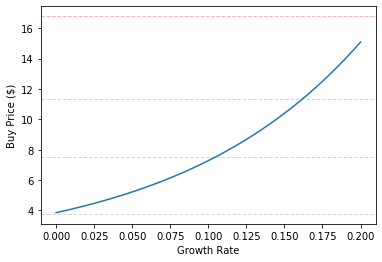

In [7]:
car_data = pd.read_csv('car.csv', index_col=0).transpose()
car = Company('car', car_data)
stock_analysis_output(car, 0.20)

AVG revenue growth
 7.93 

AVG EPS growth
 19.4 

Cash for owners
 2010       NaN
2011    118.43
2012    129.53
2013     18.27
2014     81.07
2015    164.66
2016    153.89
2017    204.08
2018    212.03
2019    186.08
dtype: float64 

AVG cash growth
 48.51 

ROIC
 2010      NaN
2011    23.41
2012    31.98
2013     3.49
2014    14.40
2015    41.16
2016    24.12
2017    30.10
2018    28.08
2019    20.58
dtype: float64 

P/E
 2010    27.43
2011    24.68
2012    62.90
2013    27.41
2014    35.27
2015    34.51
2016    31.97
2017    35.84
2018    42.75
2019    37.71
dtype: float64 

Debt to equity
 2010    0.71
2011    0.47
2012    0.83
2013    1.14
2014    1.40
2015    1.45
2016    1.13
2017    1.09
2018    0.89
2019    0.90
dtype: float64 

Current ratio - assets to liabilities
 2010    2.10
2011    1.93
2012    1.43
2013    2.11
2014    2.48
2015    1.21
2016    2.16
2017    1.69
2018    2.03
2019    1.76
dtype: float64 

 Current price (red line)
 193.97


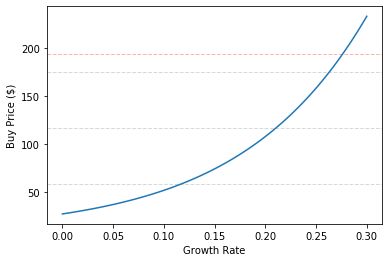

In [8]:
coh_data = pd.read_csv('coh.csv', index_col=0).transpose()
coh = Company('coh', coh_data)
stock_analysis_output(coh, 0.30)

AVG revenue growth
 12.16 

AVG EPS growth
 15.14 

Cash for owners
 2010        NaN
2011     792.43
2012     884.19
2013    1030.15
2014    1040.58
2015    1342.57
2016     901.39
2017     588.66
2018    1446.82
2019     795.03
dtype: float64 

AVG cash growth
 11.41 

ROIC
 2010      NaN
2011    20.82
2012    19.61
2013    20.52
2014    19.52
2015    20.61
2016    11.90
2017     6.47
2018    13.01
2019     5.89
dtype: float64 

P/E
 2010    18.70
2011    20.60
2012    16.78
2013    22.37
2014    25.16
2015    23.94
2016    28.10
2017    30.95
2018    31.71
2019    45.11
dtype: float64 

Debt to equity
 2010    0.35
2011    0.39
2012    0.70
2013    0.99
2014    0.99
2015    1.33
2016    1.95
2017    1.88
2018    1.64
2019    1.47
dtype: float64 

Current ratio - assets to liabilities
 2010    4.24
2011    2.92
2012    3.63
2013    3.60
2014    3.80
2015    3.57
2016    2.78
2017    2.84
2018    2.61
2019    2.53
dtype: float64 

 Current price (red line)
 278.4


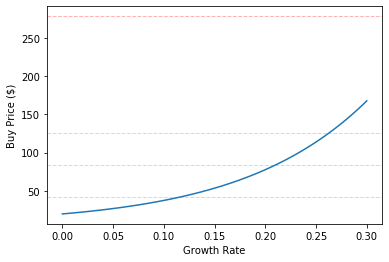

In [9]:
csl_data = pd.read_csv('csl.csv', index_col=0).transpose()
csl = Company('csl', csl_data)
stock_analysis_output(csl, 0.30)

AVG revenue growth
 29.89 

AVG EPS growth
 41.25 

Cash for owners
 2009       NaN
2010       NaN
2011     11.30
2012      4.88
2013     12.67
2014     10.57
2015     22.33
2016     63.97
2017     57.73
2018     81.75
2019    110.71
dtype: float64 

AVG cash growth
 56.41 

ROIC
 2009      NaN
2010      NaN
2011    29.74
2012     9.21
2013    17.36
2014     7.95
2015     9.46
2016    21.68
2017    13.49
2018    16.35
2019    18.09
dtype: float64 

P/E
 2009      NaN
2010    36.60
2011    16.85
2012    23.81
2013    32.94
2014    62.47
2015    42.00
2016    41.14
2017    49.04
2018    39.06
2019    10.13
dtype: float64 

Debt to equity
 2009     NaN
2010    0.47
2011    0.53
2012    0.58
2013    0.66
2014    0.86
2015    0.86
2016    1.10
2017    0.85
2018    0.71
2019    0.69
dtype: float64 

Current ratio - assets to liabilities
 2009     NaN
2010    1.25
2011    1.47
2012    1.36
2013    1.31
2014    1.29
2015    1.21
2016    1.07
2017    1.04
2018    1.17
2019    1.30
dtype: float6

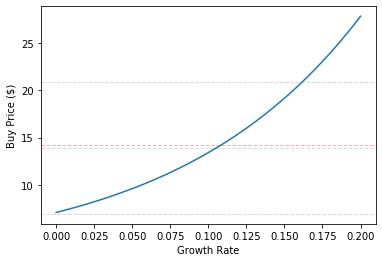

In [10]:
ctd_data = pd.read_csv('ctd.csv', index_col=0).transpose()
ctd = Company('ctd', ctd_data)
stock_analysis_output(ctd, 0.20)


AVG revenue growth
 15.09 

AVG EPS growth
 9.93 

Cash for owners
 2009      NaN
2010    18.00
2011    -9.00
2012    32.23
2013   -15.00
2014    -2.78
2015     7.80
2016     1.97
2017    -1.57
2018   -10.70
2019    30.45
dtype: float64 

AVG cash growth
 -141.58 

ROIC
 2009      NaN
2010    12.08
2011    -4.86
2012    17.05
2013    -6.02
2014    -0.92
2015     2.66
2016     0.50
2017    -0.38
2018    -2.20
2019     6.14
dtype: float64 

P/E
 2009      NaN
2010      NaN
2011     8.85
2012     6.89
2013    10.30
2014    13.44
2015     9.91
2016     7.82
2017     9.12
2018    10.72
2019     9.34
dtype: float64 

Debt to equity
 2009    0.74
2010    0.89
2011    0.80
2012    0.29
2013    0.45
2014    0.56
2015    0.34
2016    0.48
2017    0.53
2018    0.70
2019    0.52
dtype: float64 

Current ratio - assets to liabilities
 2009    2.45
2010    0.78
2011    1.40
2012    2.18
2013    1.98
2014    1.35
2015    1.38
2016    1.33
2017    2.34
2018    2.03
2019    3.17
dtype: float64 

 Curre

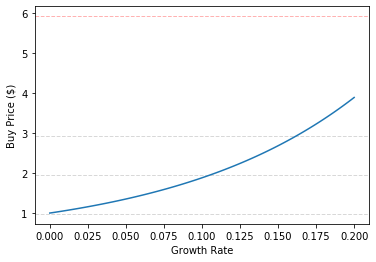

In [11]:
cwp_data = pd.read_csv('cwp_test.csv', index_col=0).transpose()
cwp = Company('cwp', cwp_data)
stock_analysis_output(cwp, 0.20)

- EPD.AX: No data found for this date range, symbol may be delisted
- EPD.AX: No data found for this date range, symbol may be delisted
AVG revenue growth
 25.44 

AVG EPS growth
 -96.9 

Cash for owners
 2010     NaN
2011    1.30
2012   -3.67
2013   -1.83
2014    0.88
2015   -0.76
2016    1.00
2017   -0.54
2018    7.36
2019   -2.88
dtype: float64 

AVG cash growth
 -344.32 

ROIC
 2010      NaN
2011    21.67
2012   -33.36
2013   -10.17
2014     2.00
2015    -1.17
2016     1.82
2017    -0.68
2018     7.67
2019    -3.65
dtype: float64 

P/E
 2010      NaN
2011      NaN
2012    16.50
2013    30.00
2014    15.25
2015    16.80
2016   -39.00
2017    22.50
2018    15.33
2019    -4.00
dtype: float64 

Debt to equity
 2010    0.83
2011    1.33
2012    0.91
2013    1.07
2014    0.94
2015    1.30
2016    1.27
2017    0.68
2018    0.75
2019    0.76
dtype: float64 

Current ratio - assets to liabilities
 2010    1.00
2011    1.12
2012    1.44
2013    1.10
2014    1.28
2015    1.07
2016    0.79
201

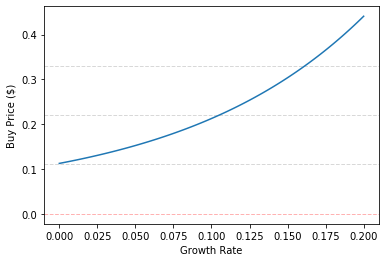

In [12]:
epd_data = pd.read_csv('epd.csv', index_col=0).transpose()
epd = Company('epd', epd_data)
stock_analysis_output(epd, 0.20)

AVG revenue growth
 11.76 

AVG EPS growth
 8.46 

Cash for owners
 2010       NaN
2011     68.47
2012    171.49
2013    122.90
2014      6.82
2015    139.93
2016    136.97
2017    156.57
2018    247.66
2019    245.00
dtype: float64 

AVG cash growth
 256.09 

ROIC
 2010      NaN
2011    17.78
2012    51.19
2013    33.40
2014     1.44
2015    29.03
2016    26.60
2017    11.08
2018    17.48
2019    16.52
dtype: float64 

P/E
 2010    18.40
2011    19.14
2012    11.08
2013    10.82
2014    14.78
2015    12.77
2016    14.64
2017    17.16
2018    13.54
2019    12.74
dtype: float64 

Debt to equity
 2010    1.44
2011    4.05
2012    3.39
2013    2.45
2014    1.92
2015    1.61
2016    1.45
2017    1.87
2018    1.63
2019    1.44
dtype: float64 

Current ratio - assets to liabilities
 2010    1.25
2011    1.45
2012    1.22
2013    1.28
2014    1.64
2015    1.62
2016    1.57
2017    1.32
2018    1.32
2019    1.31
dtype: float64 

 Current price (red line)
 40.47


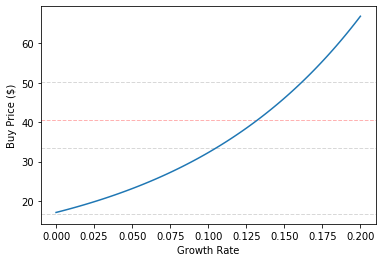

In [13]:
jbh_data = pd.read_csv('jbh.csv', index_col=0).transpose()
jbh = Company('jbh', jbh_data)
stock_analysis_output(jbh, 0.20)

AVG revenue growth
 12.28 

AVG EPS growth
 11.39 

Cash for owners
 2009      NaN
2010    15.82
2011    43.53
2012    28.77
2013    42.81
2014    36.99
2015    12.15
2016    27.97
2017    41.53
2018    55.18
2019    66.90
dtype: float64 

AVG cash growth
 38.01 

ROIC
 2009      NaN
2010     6.65
2011    18.29
2012    11.11
2013    14.76
2014    10.94
2015     3.52
2016     8.37
2017    13.06
2018    13.08
2019    14.97
dtype: float64 

P/E
 2009      NaN
2010      NaN
2011     8.47
2012    11.77
2013    17.33
2014    10.26
2015    15.78
2016    11.47
2017    12.59
2018    11.95
2019    12.17
dtype: float64 

Debt to equity
 2009    0.44
2010    0.34
2011    0.33
2012    0.33
2013    0.28
2014    0.35
2015    0.37
2016    0.34
2017    0.34
2018    0.46
2019    0.35
dtype: float64 

Current ratio - assets to liabilities
 2009    1.65
2010    1.76
2011    1.57
2012    2.03
2013    2.45
2014    2.65
2015    2.90
2016    1.79
2017    1.48
2018    1.53
2019    1.82
dtype: float64 

 Curren

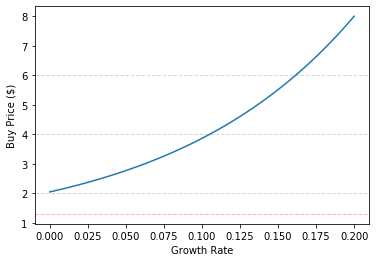

In [14]:
kmd_data = pd.read_csv('kmd_test.csv', index_col=0).transpose()
kmd = Company('kmd', kmd_data)
stock_analysis_output(kmd, 0.20)

AVG revenue growth
 24.54 

AVG EPS growth
 24.07 

Cash for owners
 2010      NaN
2011    -1.65
2012    -8.00
2013     0.00
2014     8.38
2015    15.13
2016   -15.11
2017    17.27
2018    19.39
2019     3.55
dtype: float64 

AVG cash growth
 -27.87 

ROIC
 2010      NaN
2011    -2.26
2012    -8.79
2013     0.00
2014     6.65
2015    10.02
2016    -8.54
2017     8.51
2018     7.91
2019     1.00
dtype: float64 

P/E
 2010     30.36
2011     59.79
2012     77.42
2013    172.00
2014     98.83
2015     69.81
2016     72.11
2017     38.81
2018     35.10
2019     28.96
dtype: float64 

Debt to equity
 2010    1.22
2011    1.58
2012    1.62
2013    0.69
2014    0.68
2015    0.58
2016    0.69
2017    0.71
2018    0.75
2019    0.82
dtype: float64 

Current ratio - assets to liabilities
 2010    0.67
2011    2.38
2012    4.75
2013    2.44
2014    1.67
2015    4.43
2016    2.22
2017    1.43
2018    0.69
2019    1.08
dtype: float64 

 Current price (red line)
 9.34


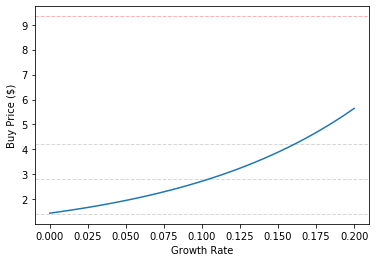

In [15]:
lic_data = pd.read_csv('lic.csv', index_col=0).transpose()
lic = Company('lic', lic_data)
stock_analysis_output(lic, 0.20)

AVG revenue growth
 5.09 

AVG EPS growth
 22.28 

Cash for owners
 2010      NaN
2011     5.00
2012     9.00
2013     6.02
2014     6.00
2015     8.00
2016    -2.00
2017     6.77
2018     9.03
2019    21.98
dtype: float64 

AVG cash growth
 -38.35 

ROIC
 2010      NaN
2011    31.25
2012    75.00
2013    43.00
2014    50.00
2015    50.00
2016   -11.11
2017    32.24
2018    36.12
2019    73.27
dtype: float64 

P/E
 2010    12.00
2011     7.33
2012    11.75
2013    11.00
2014    10.83
2015    26.00
2016    26.67
2017    24.44
2018    32.50
2019    61.50
dtype: float64 

Debt to equity
 2010    1.67
2011    0.94
2012    1.58
2013    1.36
2014    1.75
2015    1.62
2016    1.11
2017    1.19
2018    1.20
2019    1.57
dtype: float64 

Current ratio - assets to liabilities
 2010    1.12
2011    1.40
2012    1.50
2013    1.53
2014    1.32
2015    1.45
2016    1.32
2017    1.41
2018    1.36
2019    1.33
dtype: float64 

 Current price (red line)
 7.37


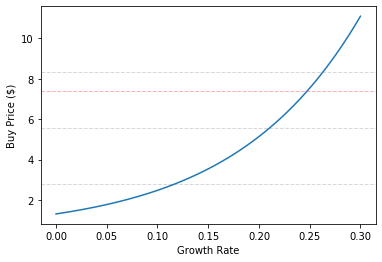

In [16]:
ocl_data = pd.read_csv('ocl.csv', index_col=0).transpose()
ocl = Company('ocl', ocl_data)
stock_analysis_output(ocl,0.30)

AVG revenue growth
 3.81 

AVG EPS growth
 106.17 

Cash for owners
 2010        NaN
2011    -353.12
2012    -271.91
2013     197.46
2014    -124.33
2015     721.99
2016    1226.83
2017    1326.93
2018    1565.69
2019     970.05
dtype: float64 

AVG cash growth
 -122.66 

ROIC
 2010      NaN
2011    -3.15
2012    -2.55
2013     1.87
2014    -1.76
2015    10.57
2016    19.43
2017    19.85
2018    21.98
2019    14.03
dtype: float64 

P/E
 2010    56.20
2011    20.67
2012   -14.92
2013      NaN
2014    -0.99
2015    10.74
2016     7.96
2017     8.04
2018    10.09
2019     5.30
dtype: float64 

Debt to equity
 2010    2.33
2011    2.39
2012    2.60
2013    2.39
2014    5.04
2015    4.09
2016    4.12
2017    3.86
2018    3.71
2019    4.64
dtype: float64 

Current ratio - assets to liabilities
 2010    0.93
2011    0.90
2012    0.77
2013    0.82
2014    0.66
2015    0.68
2016    0.49
2017    0.44
2018    0.49
2019    0.49
dtype: float64 

 Current price (red line)
 4.915


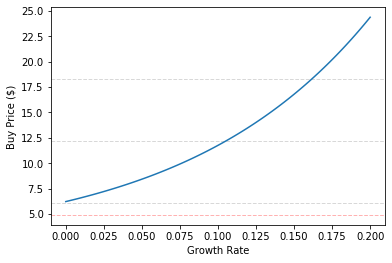

In [17]:
qan_data = pd.read_csv('qan.csv', index_col=0).transpose()
qan = Company('qan', qan_data)
stock_analysis_output(qan, 0.20)

AVG revenue growth
 19.42 

AVG EPS growth
 14.04 

Cash for owners
 2010       NaN
2011     58.88
2012     71.32
2013    126.80
2014    164.01
2015    155.91
2016    187.79
2017    246.30
2018    280.34
2019    301.35
dtype: float64 

AVG cash growth
 24.53 

ROIC
 2010      NaN
2011    29.89
2012    28.41
2013    40.25
2014    40.20
2015    27.94
2016    15.55
2017    21.16
2018    22.41
2019    30.91
dtype: float64 

P/E
 2010     25.67
2011     22.26
2012     20.05
2013     32.17
2014     43.37
2015     30.70
2016     25.99
2017     36.41
2018     40.59
2019    115.00
dtype: float64 

Debt to equity
 2010    0.33
2011    0.26
2012    0.20
2013    0.25
2014    0.27
2015    0.20
2016    1.07
2017    0.96
2018    0.83
2019    0.75
dtype: float64 

Current ratio - assets to liabilities
 2010    2.79
2011    3.59
2012    4.98
2013    4.26
2014    3.17
2015    1.59
2016    0.96
2017    1.21
2018    0.93
2019    0.69
dtype: float64 

 Current price (red line)
 107.09


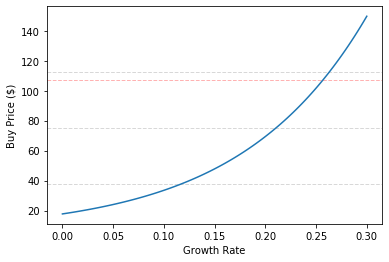

In [18]:
rea_data = pd.read_csv('rea.csv', index_col=0).transpose()
rea = Company('rea', rea_data)
stock_analysis_output(rea, 0.30)

AVG revenue growth
 14.35 

AVG EPS growth
 17.37 

Cash for owners
 2009       NaN
2010    169.99
2011    234.57
2012    224.80
2013    197.83
2014    353.84
2015    420.07
2016    473.32
2017    452.94
2018    545.38
2019    431.59
dtype: float64 

AVG cash growth
 14.15 

ROIC
 2009      NaN
2010     6.76
2011     9.35
2012     9.27
2013     7.15
2014    11.55
2015     9.69
2016     9.14
2017     8.33
2018     8.99
2019     5.24
dtype: float64 

P/E
 2009      NaN
2010    25.19
2011    20.18
2012    27.30
2013    39.49
2014    44.62
2015    33.86
2016    32.41
2017    28.63
2018    32.62
2019    29.46
dtype: float64 

Debt to equity
 2009    2.51
2010    1.92
2011    1.72
2012    1.55
2013    1.63
2014    1.61
2015    3.16
2016    3.04
2017    2.53
2018    2.81
2019    3.15
dtype: float64 

Current ratio - assets to liabilities
 2009    1.01
2010    1.09
2011    1.08
2012    0.92
2013    1.23
2014    0.96
2015    0.76
2016    0.92
2017    1.03
2018    1.19
2019    1.10
dtype: float6

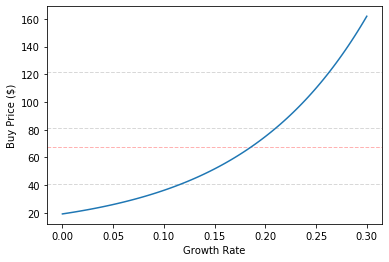

In [19]:
rhc_data = pd.read_csv('rhc.csv', index_col=0).transpose()
rhc = Company('rhc', rhc_data)
stock_analysis_output(rhc, 0.30)

AVG revenue growth
 29.3 

AVG EPS growth
 25.47 

Cash for owners
 2014       NaN
2015     24.20
2016     44.36
2017     69.00
2018     54.00
2019    102.03
dtype: float64 

AVG cash growth
 51.51 

ROIC
 2014      NaN
2015    17.79
2016    12.90
2017    19.94
2018    15.65
2019    30.28
dtype: float64 

P/E
 2014      NaN
2015     7.80
2016    15.17
2017    19.71
2018    25.41
2019     9.90
dtype: float64 

Debt to equity
 2014     NaN
2015    1.02
2016    1.26
2017    1.26
2018    0.59
2019    0.71
dtype: float64 

Current ratio - assets to liabilities
 2014     NaN
2015    1.06
2016    1.56
2017    1.08
2018    1.15
2019    1.09
dtype: float64 

 Current price (red line)
 6.95


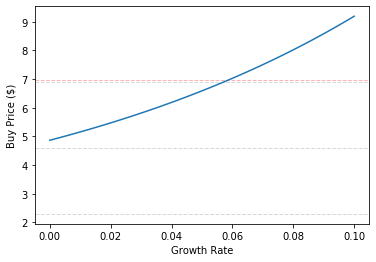

In [20]:
siq_data = pd.read_csv('siq.csv', index_col=0).transpose()
siq = Company('siq', siq_data)
stock_analysis_output(siq, 0.10)

In [21]:
txrh_data = pd.read_csv('txrh.csv', index_col=0).transpose()
txrh = Company(txrh_data)
stock_analysis_output(txrh, 0.20)

TypeError: __init__() missing 1 required positional argument: 'data'

AVG revenue growth
 42.16 

AVG EPS growth
 221.81 

Cash for owners
 2013      NaN
2014     9.70
2015     7.97
2016     7.41
2017    35.60
2018    45.64
2019    80.10
dtype: float64 

AVG cash growth
 91.86 

ROIC
 2013      NaN
2014      NaN
2015     8.22
2016     3.78
2017    16.56
2018    12.93
2019    10.43
dtype: float64 

P/E
 2013       NaN
2014       NaN
2015       NaN
2016    400.00
2017     49.55
2018     78.43
2019     50.00
dtype: float64 

Debt to equity
 2013     NaN
2014     NaN
2015    0.93
2016    0.26
2017    0.29
2018    0.53
2019    0.47
dtype: float64 

Current ratio - assets to liabilities
 2013     NaN
2014     NaN
2015    2.16
2016    3.53
2017    2.93
2018    2.01
2019    1.92
dtype: float64 

 Current price (red line)
 22.88


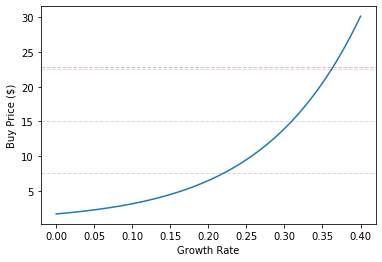

In [22]:
wtc_data = pd.read_csv('wtc.csv', index_col=0).transpose()
wtc = Company('wtc', wtc_data)
stock_analysis_output(wtc, 0.40)

AVG revenue growth
 7.31 

AVG EPS growth
 14.58 

Cash for owners
 2009     NaN
2010   -0.31
2011    2.35
2012    3.20
2013    2.91
2014    1.95
2015    2.95
2016   -3.00
2017   -1.91
2018   -0.83
2019    3.17
dtype: float64 

AVG cash growth
 -176.57 

ROIC
 2009      NaN
2010    -2.07
2011    11.75
2012    11.85
2013    10.03
2014     6.72
2015     9.83
2016    -9.68
2017    -5.97
2018    -2.52
2019     8.81
dtype: float64 

P/E
 2009      NaN
2010      NaN
2011     9.00
2012    12.00
2013     9.00
2014    10.50
2015     8.50
2016    17.00
2017    20.00
2018    16.00
2019     8.33
dtype: float64 

Debt to equity
 2009    0.13
2010    0.13
2011    0.26
2012    0.15
2013    0.07
2014    0.07
2015    0.07
2016    0.10
2017    0.13
2018    0.19
2019    0.24
dtype: float64 

Current ratio - assets to liabilities
 2009    4.50
2010    4.50
2011    2.25
2012    3.75
2013    7.50
2014    6.50
2015    6.50
2016    6.00
2017    5.50
2018    2.60
2019    2.67
dtype: float64 

 Current price (r

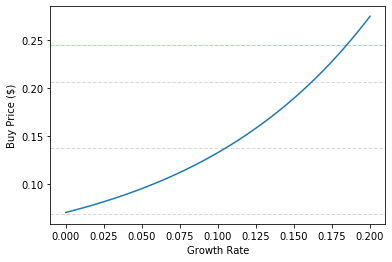

In [23]:
xrf_data = pd.read_csv('xrf.csv', index_col=0).transpose()
xrf = Company('xrf', xrf_data)
stock_analysis_output(xrf, 0.20)